In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report,
                           precision_score, recall_score, f1_score, matthews_corrcoef)
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:

def create_confidence_based_split(metadata_df, rnaseq_df):
    """Create train-test split based on confidence scores"""
    # Create high confidence sets
    hi_c_low = metadata_df[metadata_df['Confidence'] <= 0.1].index
    hi_c_high = metadata_df[metadata_df['Confidence'] >= 0.9].index
    
    # Create ambiguous set for testing
    amb = metadata_df[(metadata_df['Confidence'] > 0.1) & 
                     (metadata_df['Confidence'] < 0.9)].index
    
    # Combine high confidence samples for training
    train_indices = list(hi_c_low) + list(hi_c_high)
    test_indices = list(amb)
    
    # Create the splits
    X_train = rnaseq_df.loc[train_indices]
    X_test = rnaseq_df.loc[test_indices]
    y_train = metadata_df.loc[train_indices, 'HRD_status_base']
    y_test = metadata_df.loc[test_indices, 'HRD_status_base']
    
    print(f"Training set size: {len(train_indices)}")
    print(f"Test set size: {len(test_indices)}")
    
    return X_train, X_test, y_train, y_test

def preprocess_data(X_train, X_test):
    """Scale the features"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """Calculate various performance metrics"""
    metrics = {
        'Precision': precision_score(y_true, y_pred, pos_label='HRD'),
        'Recall': recall_score(y_true, y_pred, pos_label='HRD'),
        'F1': f1_score(y_true, y_pred, pos_label='HRD'),
        'MCC': matthews_corrcoef(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'Classification Report': classification_report(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_true == 'HRD', y_pred_proba)
        metrics['ROC'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc(fpr, tpr)}
    
    return metrics

def train_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test, feature_names):
    """Train and evaluate models"""
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train_scaled, y_train)
        
        # Get predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calculate metrics
        results[name] = calculate_metrics(y_test, y_pred, y_pred_proba)
        
        # Print results
        print(f"\n{name} Results:")
        print(f"AUC: {results[name]['ROC']['auc']:.3f}")
        print(f"Precision: {results[name]['Precision']:.3f}")
        print(f"Recall: {results[name]['Recall']:.3f}")
        print(f"F1: {results[name]['F1']:.3f}")
        print(f"MCC: {results[name]['MCC']:.3f}")
        print("\nConfusion Matrix:")
        print(results[name]['Confusion Matrix'])
        print("\nClassification Report:")
        print(results[name]['Classification Report'])
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(results[name]['ROC']['fpr'], results[name]['ROC']['tpr'], 
                label=f'ROC curve (AUC = {results[name]["ROC"]["auc"]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    return results

def main(rnaseq_df, brca_df):
    # Create confidence-based split
    X_train, X_test, y_train, y_test = create_confidence_based_split(brca_df, rnaseq_df)
    
    # Preprocess data
    X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)
    
    # Train and evaluate models
    feature_names = rnaseq_df.columns
    results = train_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test, feature_names)
    
    return results


In [7]:
brca_df = pd.read_csv('../data/soft_label.tsv', sep='\t', index_col=0)
rnaseq_df = pd.read_csv('../data/tpm.csv', index_col=0)
og_rna_df = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)

In [8]:
import pandas as pd

def match_case_ids(df1, df2):
    """
    Modify df2's index to match df1's Case ID format and compare them
    
    Parameters:
    df1: First dataframe with Case ID column
    df2: Second dataframe with TCGA sample IDs as index
    
    Returns:
    tuple: (modified df2, boolean mask of matching indices)
    """
    # Extract Case IDs from df1
    case_ids_df1 = df1['Case ID'].unique()
    
    # Convert df2's index to match Case ID format
    # Current format: TCGA-XX-XXXX-01X-XXR-XXXX-XX
    # Target format: TCGA-XX-XXXX
    new_case_ids = df2.index.str.extract('(TCGA-\w\w-\w\w\w\w)')[0]
    
    # Create a copy of df2
    df2_modified = df2.copy()
    
    # Reset the index to default numeric index and add Case ID as a column
    df2_modified = df2_modified.reset_index(drop=True)
    df2_modified.insert(0, 'Case ID', new_case_ids)
    
    # Check which case IDs match
    matching_cases = df2_modified['Case ID'].isin(case_ids_df1)
    
    # Print summary statistics
    print(f"Total cases in df1: {len(case_ids_df1)}")
    print(f"Total cases in df2: {len(df2_modified)}")
    print(f"Number of matching cases: {matching_cases.sum()}")
    print(f"Number of non-matching cases: {(~matching_cases).sum()}")
    
    return df2_modified, matching_cases

# Example usage:
# df2_modified, matches = match_case_ids(df1, df2)

# To see non-matching cases:
# non_matching_df2 = df2_modified[~matches]
# non_matching_df1 = df1[~df1['Case ID'].isin(df2_modified['Case ID'])]

<>:20: SyntaxWarning: invalid escape sequence '\w'
<>:20: SyntaxWarning: invalid escape sequence '\w'
/var/folders/tx/vgccmrkj1fz1zv99j496_3k80000gn/T/ipykernel_49723/2366072738.py:20: SyntaxWarning: invalid escape sequence '\w'
  new_case_ids = df2.index.str.extract('(TCGA-\w\w-\w\w\w\w)')[0]


In [9]:
og_rna_df_z = og_rna_df.copy()
rnaseq_df_z = rnaseq_df.copy()

df2_modified, matches = match_case_ids(og_rna_df_z, rnaseq_df_z)


Total cases in df1: 1095
Total cases in df2: 1231
Number of matching cases: 1231
Number of non-matching cases: 0


In [10]:
 # Rename the index to 'Case ID'
rnaseq_df = df2_modified
df2_modified.head()


,Case ID,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,...,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
0,TCGA-5L-AAT0,64.3002,0.3433,77.0779,9.9974,4.1080,10.9674,21.9577,39.5030,9.3605,...,0,0.0,0.6935,0,0.0,0.0,10.5998,0,0.0527,0.6032
1,TCGA-A2-A04U,79.8321,1.0345,231.9536,5.4463,3.0821,3.1379,5.8744,36.4695,6.7241,...,0,0.0,0.1608,0,0.0,0.0,37.0966,0,0.1032,0.4090
2,TCGA-AN-A04A,15.6522,0.3055,82.2766,8.9320,2.3835,3.1853,25.2157,48.8798,5.0582,...,0,0.0,0.0528,0,0.0,0.0,7.7362,0,0.0000,0.9544
3,TCGA-A7-A13D,33.1976,0.0000,116.4500,4.2842,9.0514,3.4080,9.3476,45.1569,5.3149,...,0,0.0,0.2276,0,0.0,0.0,12.0389,0,0.0415,0.1188
4,TCGA-BH-A201,43.9791,1.1406,117.9486,15.2048,8.3656,11.7971,30.6031,43.2496,16.0961,...,0,0.0,0.3742,0,0.0,0.0,18.3220,0,0.0642,0.9353


In [11]:

# Drop rows where event.BRCA1 is '1'
brca_df_filtered = brca_df[brca_df['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.PALB2'] != '2']

# keep common samples

#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
brca_samples = set(brca_df_filtered.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))

# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)


Number of common samples: 857
rnaseq_df_common: (921, 60661)
brca_df_common: (857, 41)


In [12]:
# Check for duplicates in rnaseq_df_common's Case ID
print("Duplicate Case IDs in rnaseq_df:", rnaseq_df_common['Case ID'].duplicated().sum())

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

# Verify the shapes after removing duplicates
print("\nAfter removing duplicates:")
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

# Verify that we have exactly the same samples in both dataframes
rnaseq_samples = set(rnaseq_df_common['Case ID'])
brca_samples = set(brca_df_common.index)
print("\nSamples match:", rnaseq_samples == brca_samples)
print("Number of samples in each:", len(rnaseq_samples), len(brca_samples))

rnaseq_df_common.set_index('Case ID', inplace=True)
rnaseq_df_common.head()

Duplicate Case IDs in rnaseq_df: 64

After removing duplicates:
rnaseq_df_common: (857, 60661)
brca_df_common: (857, 41)

Samples match: True
Number of samples in each: 857 857


,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-AN-A04A,15.6522,0.3055,82.2766,8.9320,2.3835,3.1853,25.2157,48.8798,5.0582,20.4705,...,0,0.0,0.0528,0,0.0,0.0,7.7362,0,0.0000,0.9544
TCGA-BH-A201,43.9791,1.1406,117.9486,15.2048,8.3656,11.7971,30.6031,43.2496,16.0961,55.8942,...,0,0.0,0.3742,0,0.0,0.0,18.3220,0,0.0642,0.9353
TCGA-BH-A0H6,91.8891,1.4798,94.2877,10.1657,3.7848,5.6121,14.7899,63.9481,25.9042,48.9734,...,0,0.0,0.3833,0,0.0,0.0,13.8798,0,0.0548,0.7173
TCGA-A2-A0YL,77.5579,0.8524,96.8820,21.7993,11.1025,9.5936,40.7250,50.4946,15.3437,51.1862,...,0,0.0,0.3253,0,0.0,0.0,12.5688,0,0.0482,1.2218
TCGA-A2-A04R,21.1591,0.3341,93.2046,15.3681,10.4596,2.8069,9.6867,34.6658,11.4874,82.2981,...,0,0.0,0.2704,0,0.0,0.0,13.9865,0,0.0256,0.4036


In [13]:

# Sort the samples in both dataframes by index
rnaseq_df_common = rnaseq_df_common.sort_index()
brca_df_common = brca_df_common.sort_index()

# Verify indices match exactly
indices_match = (rnaseq_df_common.index == brca_df_common.index).all()
print("\nIndices match exactly:", indices_match)



Indices match exactly: True


In [14]:
dick = {}
for i, v in enumerate(og_rna_df.columns):
    if i > 2:
        dick[v.split('|')[0]] =v.split('|')[1]
tpm2 = rnaseq_df_common.rename(columns=dick)

In [15]:
tpm2.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AL451106.1,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,79.5795,35.6112,86.0860,12.5926,4.9124,2.8562,98.6264,24.2999,14.3087,53.0680,...,0,0.0,0.3665,0,0.0,0.0,10.4987,0,0.0995,1.3468
TCGA-A1-A0SD,34.4197,2.1352,144.9138,13.0952,3.9592,7.6785,39.0666,75.2038,27.3393,64.2218,...,0,0.0,0.2765,0,0.0,0.0,12.2783,0,0.0131,0.7129
TCGA-A1-A0SE,70.7498,1.0254,81.6615,16.2075,13.8165,3.8598,22.5774,28.8716,11.5469,81.2141,...,0,0.0,0.1770,0,0.0,0.0,21.5324,0,0.0197,1.1261
TCGA-A1-A0SF,134.1201,0.4122,90.9602,12.4050,5.1298,11.5339,23.1446,33.9457,11.1235,50.0245,...,0,0.0,0.2254,0,0.0,0.0,16.2369,0,0.0281,1.2877
TCGA-A1-A0SG,43.7408,0.1801,96.1508,9.6472,4.4312,7.1932,25.5795,50.0516,16.1042,42.2078,...,0,0.0,0.1983,0,0.0,0.0,17.2516,0,0.0276,1.8595


In [16]:
# filter to top 2 percent of differentially expressed genes
deseq_results=pd.read_csv('../data/deseq_bottom_2_percent.tsv', sep = '\t', index_col=0)


In [17]:

# # Filter columns in rna_seq_df based on deseq_results row indices
# deseq_filtered_rna_seq_df = rnaseq_df_common[[col for col in rnaseq_df_common.columns if col in deseq_results.index.split('|')[0]]]
# print(deseq_filtered_rna_seq_df.shape)
# deseq_filtered_rna_seq_df.head()

# Extract gene IDs from DESeq results index
gene_ids = [idx.split('|')[0] for idx in deseq_results.index]

# Filter columns in RNA-seq data based on DESeq gene IDs 
deseq_filtered_rna_seq_df = rnaseq_df_common[[col for col in rnaseq_df_common.columns if col in gene_ids]]

print("Original RNA-seq shape:", rnaseq_df_common.shape)
print("Filtered RNA-seq shape:", deseq_filtered_rna_seq_df.shape)
print("\nFirst few rows of filtered data:")
print(deseq_filtered_rna_seq_df.head())

# Verify overlap between DESeq genes and RNA-seq columns
n_overlap = len(set(gene_ids) & set(deseq_filtered_rna_seq_df.columns))
print(f"\nNumber of overlapping genes: {n_overlap}")
print(f"Percent of DESeq genes retained: {100*n_overlap/len(gene_ids):.1f}%")

Original RNA-seq shape: (857, 60660)
Filtered RNA-seq shape: (857, 1213)

First few rows of filtered data:
              ENSG00000001617.12  ENSG00000003147.19  ENSG00000003756.17  \
Case ID                                                                    
TCGA-A1-A0SB             31.9170             31.9008             31.6601   
TCGA-A1-A0SD             92.3784             39.1894             26.6559   
TCGA-A1-A0SE            143.3067             42.1014             20.9881   
TCGA-A1-A0SF             76.3172             37.3393             14.5495   
TCGA-A1-A0SG            106.9473             29.6338             17.7643   

              ENSG00000004838.14  ENSG00000005194.15  ENSG00000006016.11  \
Case ID                                                                    
TCGA-A1-A0SB              1.6266             57.0037             17.8329   
TCGA-A1-A0SD              7.7234             37.0957              7.9453   
TCGA-A1-A0SE             38.0684             38.1577    

In [18]:
#Filter to top 2% of all protein genes
#drop non-protein coding genes

# Step 1: Filter for protein coding genes (from your original code)
columns_to_keep = ['Sample ID', 'Sample Type']
gene_columns = [col for col in tpm2.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
pcg_rnaseq_df_filtered = tpm2[final_columns]


# Step 2: Calculate mean expression for each gene
# First, separate metadata columns from gene expression columns
gene_expression = pcg_rnaseq_df_filtered[protein_coding_cols]
metadata = pcg_rnaseq_df_filtered[columns_to_keep]


# Calculate mean expression for each gene
gene_means = gene_expression.mean(axis=0)

# Calculate number of genes to keep (top 2%)
n_genes_to_keep = 400

# Get the column names (genes) with highest mean expression
top_genes = gene_means.nlargest(n_genes_to_keep).index

# Create final dataframe with metadata and top genes
pcg_400_with_metadata = pd.concat([metadata, pcg_rnaseq_df_filtered[top_genes]], axis=1)

# Create final dataframe with only top genes
pcg_400 = pcg_rnaseq_df_filtered[top_genes]

# Print information about the filtering
print("Original number of protein coding genes:", len(protein_coding_cols))
print("Number of top genes kept (2%):", n_genes_to_keep)
print("\nDataframe shapes:")
print("Original:", rnaseq_df.shape)
print("After protein coding filter:", pcg_rnaseq_df_filtered.shape)
print("Final (with top 2% genes) with metadata:", pcg_400_with_metadata.shape)
print("Final (with top 2% genes):", pcg_400.shape)



# Optional: Show summary statistics of the mean expression values
print("\nMean expression summary for top genes:")
print(gene_means[top_genes].describe())

# Save results to new dataframe
rnaseq_df_top_genes = pcg_400

# Optional: verify that our key columns are still present
print("\nChecking if key columns are present:")
for col in columns_to_keep:
    print(f"{col} present: {col in rnaseq_df_top_genes.columns}")

KeyError: "None of [Index(['Sample ID', 'Sample Type'], dtype='object')] are in the [columns]"

In [20]:
#files to use for training/testing

#top 2% of expressed protein coding genes
# rnaseq_df_top_genes.head()
# print(rnaseq_df_top_genes.shape)

#top 2% of differentially expressed genes
deseq_filtered_rna_seq_df.head()
print(deseq_filtered_rna_seq_df.shape)

#metadata with soft labels
brca_df_common.head()
print(brca_df_common.shape)


(857, 1213)
(857, 41)


Training set size: 575
Test set size: 282

Training Elastic Net...

Elastic Net Results:
AUC: nan
Precision: 0.000
Recall: 0.000
F1: 0.000
MCC: 0.000

Confusion Matrix:
[[136 146]
 [  0   0]]

Classification Report:
              precision    recall  f1-score   support

          HR       1.00      0.48      0.65       282
         HRD       0.00      0.00      0.00         0

    accuracy                           0.48       282
   macro avg       0.50      0.24      0.33       282
weighted avg       1.00      0.48      0.65       282



/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/metrics

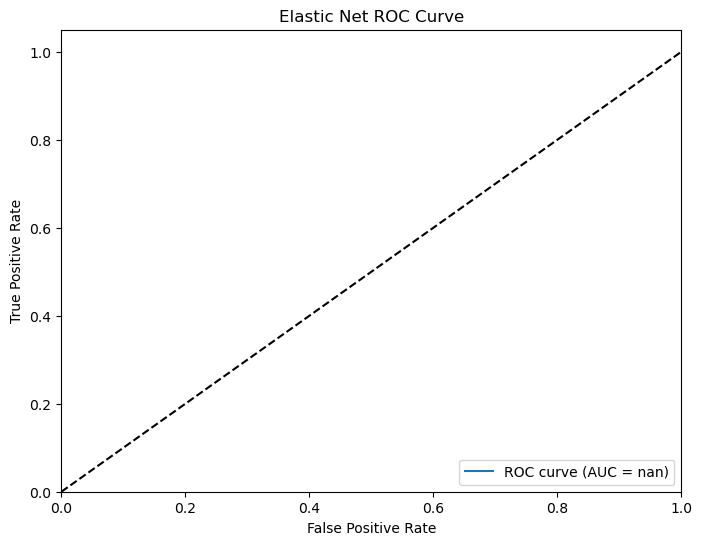


Training Random Forest...

Random Forest Results:
AUC: nan
Precision: 0.000
Recall: 0.000
F1: 0.000
MCC: 0.000

Confusion Matrix:
[[151 131]
 [  0   0]]

Classification Report:
              precision    recall  f1-score   support

          HR       1.00      0.54      0.70       282
         HRD       0.00      0.00      0.00         0

    accuracy                           0.54       282
   macro avg       0.50      0.27      0.35       282
weighted avg       1.00      0.54      0.70       282



/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

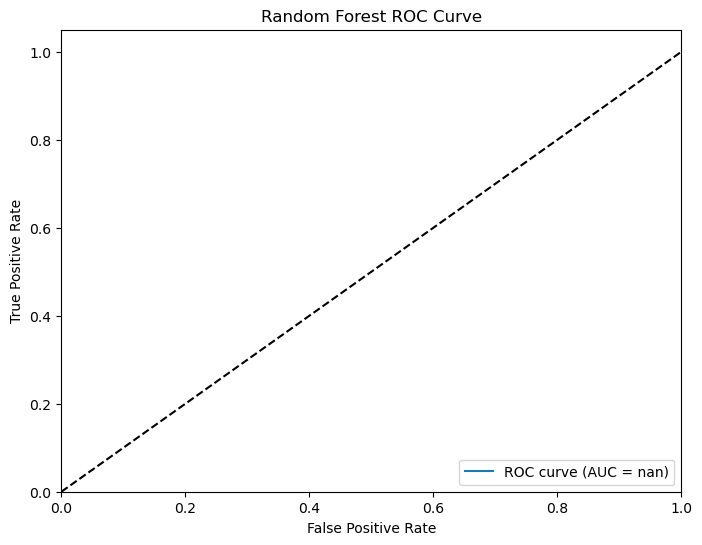


Training Gradient Boosting...

Gradient Boosting Results:
AUC: nan
Precision: 0.000
Recall: 0.000
F1: 0.000
MCC: 0.000

Confusion Matrix:
[[146 136]
 [  0   0]]

Classification Report:
              precision    recall  f1-score   support

          HR       1.00      0.52      0.68       282
         HRD       0.00      0.00      0.00         0

    accuracy                           0.52       282
   macro avg       0.50      0.26      0.34       282
weighted avg       1.00      0.52      0.68       282



/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

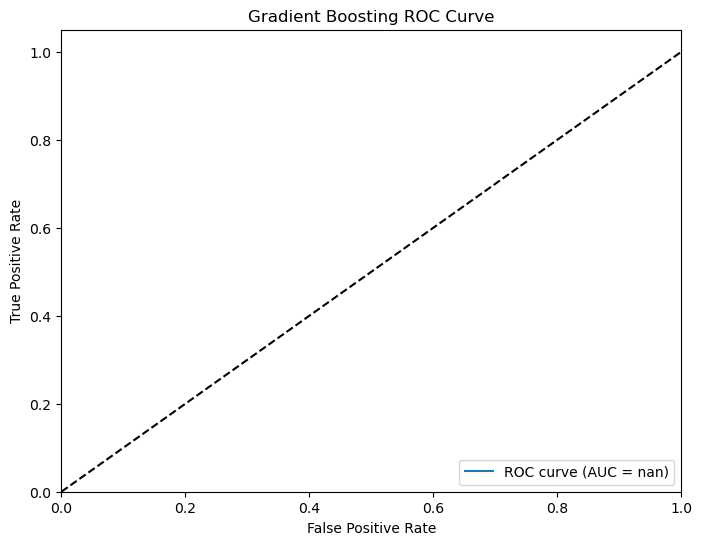

: 

In [21]:
# Run the analysis
results = main(deseq_filtered_rna_seq_df, brca_df_common)